# Example notebook: Studying and mitigating the effects of data drifts on ML model performance 
## Evaluate strategies over multiple endpoints using boxplots

This notebook is part of the supporting information to the manuscript entitled: *Studying and mitigating the effects of data drifts on ML model performance at the example of chemical toxicity data*
* Authors: A. Morger, M. Garcia de Lomana, U. Norinder, F. Svensson, J. Kirchmair, M. Mathea, A. Volkamer
* Last updated: August 2021

This notebook illustrates 
* how to build and evaluate models for several endpoints at time: For each endpoint, ACP's are trained without and with updating the calibration set. In this example, the calibration set is even updated twice. 
* how the predictions could be evaluated using boxplots: For comparison over all endpoints, the balanced validity, balanced efficiency and balanced accuracy are calculated and plotted in a boxplot.

### Import packages and modules

In [1]:
import pandas as pd
import numpy as np
import sys
import math
import tarfile

In [2]:
import matplotlib.pyplot as plt

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor

In [4]:
from nonconformist.nc import InverseProbabilityErrFunc, NcFactory

In [5]:
from continuous_calibration import (
StratifiedRatioSampler, BalancedStratifiedRatioSampler, CrossValidationSampler, InductiveConformalPredictor, 
    ContinuousCalibrationAggregatedConformalPredictor, CrossValidator
)
from continuous_calibration_helper_functions import boxplot_val_eff_acc_quer

### Define paths and parameters

Note that due to the size of the collected ChEMBL datasets containing the precalculated ChemBio descriptors, they were uploaded to [Zenodo](link_to_zenodo). Please download them first and copy the compressed file to the `data` folder to continue with the following code.

In [6]:
data_path = "../data/chembl_chembio_descriptors.tar.bz2"
time_split_threshold_path = "../data/data_size_chembio_chembl.csv"

In [7]:
# Note: Running the calculations for all endpoints takes time. If you only want to test the notebook,
# it is recommended to only select a few endpoints (i.e. comment the rest out)
endpoint_dict = {
    "CHEMBL279": ["VEGFR 2", "Vascular endothelial growth factor receptor 2"],
    "CHEMBL220": ["Acetylcholinesterase"],
    "CHEMBL4078": ["Acetylcholinesterase"],
    "CHEMBL5763": ["Cholinesterase"],
    "CHEMBL203": ["EGFR erbB1", "Epidermal growth factor receptor erbB1"],
    "CHEMBL206": ["Estrogen receptor alpha"],
    "CHEMBL222": ["Norepinephrine transporter"],
    "CHEMBL228": ["Serotonin transporter"],
    "CHEMBL230": ["Cyclooxygenase-2"],
    "CHEMBL340": ["Cytochrome P450 3A4"],
    "CHEMBL240": ["HERG"],
    "CHEMBL2039": ["Monoamine oxidase B"],
}

endpoints = list(endpoint_dict.keys())
print(endpoints)

['CHEMBL279', 'CHEMBL220', 'CHEMBL4078', 'CHEMBL5763', 'CHEMBL203', 'CHEMBL206', 'CHEMBL222', 'CHEMBL228', 'CHEMBL230', 'CHEMBL340', 'CHEMBL240', 'CHEMBL2039']


ML parameters

In [8]:
n_trees = 20 #50
n_folds_acp = 3 # 20

Boxplot parameters

In [9]:
evaluation_measures = ["validity_bal", "efficiency_bal", "accuracy_bal"]
significance_level = 0.2

### Define helper functions

In [10]:
def load_data_per_endpoint(data_dict, endpoint):
    data = data_dict[endpoint]
    data.dropna(subset=["year"], inplace=True)
    y = data[f"{endpoint}_bioactivity"].values
    columns = [col for col in data.columns if col.startswith('p') or col.startswith('byte')]
    X = data[columns].values
    years = data["year"].values
    return X, y, years

In [11]:
def split_data_per_endpoint(X, y, years, splits_df):
    
    # collect the year thresholds to split the data
    thresholds = splits_df["train_thresh"][endpoint], splits_df["update1_thresh"][endpoint], splits_df["update2_thresh"][endpoint]
    
    # get the indices tht define how to split the data
    mask_train = years <= thresholds[0]
    mask_update1 = (years > thresholds[0]) & (years <= thresholds[1])
    mask_update2 = (years > thresholds[1]) & (years <= thresholds[2])
    mask_holdout = years > thresholds[2]
    
    # split the data
    X_train, y_train = X[mask_train], y[mask_train]
    X_update1, y_update1 = X[mask_update1], y[mask_update1]
    X_update2, y_update2 = X[mask_update2], y[mask_update2]
    X_holdout, y_holdout = X[mask_holdout], y[mask_holdout]
    
    return X_train, X_update1, X_update2, X_holdout, y_train, y_update1, y_update2, y_holdout

In [12]:
def prepare_rf_acp():
    clf = RandomForestClassifier(n_estimators=n_trees)
    error_function = InverseProbabilityErrFunc()
    nc = NcFactory.create_nc(clf, err_func=error_function, normalizer_model=None)
    icp = InductiveConformalPredictor(nc_function=nc, condition=(lambda instance: instance[1]), 
                                      smoothing=False)
    ratio_sampler = StratifiedRatioSampler(n_folds=n_folds_acp)
    acp = ContinuousCalibrationAggregatedConformalPredictor(
        predictor=icp, sampler=ratio_sampler, aggregation_func=np.median)
    return acp

### Load data

#### Load prepared ChEMBL datasets containing the ChemBio descriptors, labels (activity) and publication year

Due to the size of the datasets containing the chembio descriptors, they were uploaded to zenodo (link_to_zenodo) as `tar.bz2` files and need to be unpacked first.

In [13]:
# unpack file
tar = tarfile.open(data_path)

The data is collected in the `files` dict, containing as keys the ChEMBL endpoint name and as value the dataframe

In [14]:
files = {}
# unpack the individual files
for i, name in zip(tar, tar.getnames()):
    file = tar.extractfile(i)
    if file:  # Extraction also yields an empty folder (?) which will be ignored
        n = name.split("/")[1].split('_')[0]  # Get ChEMBL endpoint name from filename     
        df = pd.read_csv(file)  # Read df
        files[n] = df  # Store in dict

#### Load dataframe defining time-split thresholds per endpoint

In [15]:
splits_df = pd.read_csv(time_split_threshold_path, index_col=0, 
                        usecols=["chembl_id", "train_thresh", "update1_thresh", "update2_thresh"])
splits_df

,train_thresh,update1_thresh,update2_thresh
chembl_id,,,
CHEMBL220,2014,2016,2017
CHEMBL4078,2014,2015,2016
CHEMBL5763,2015,2016,2017
CHEMBL203,2012,2014,2016
CHEMBL206,2006,2012,2016
CHEMBL279,2010,2013,2014
CHEMBL230,2010,2013,2015
CHEMBL340,2012,2014,2015
CHEMBL240,2012,2014,2016


### Run experiment (train different acps, calibrate, and predict) for all endpoints

In [16]:
evaluation_dfs = {"cv_original": [], 'original': [], 
                  'update1': [], 'update2': []}
for endpoint in endpoints:
    print(endpoint)
    # Prepare data
    X, y, years = load_data_per_endpoint(files, endpoint)
    X_train, X_update1, X_update2, X_holdout,\
    y_train, y_update1, y_update2, y_holdout = split_data_per_endpoint(
        X, y, years, splits_df
    )
    print(y_train.sum(), y_update1.sum(), y_update2.sum(), y_holdout.sum())
    
    # Define ACP and crossvalidator
    acp = prepare_rf_acp()
    cross_validator = CrossValidator(predictor=acp, cv_splitter=CrossValidationSampler())
    # Crossvalidate using 'original' calibration set
    cross_validator.cross_validate(
        X_train=X_train, y_train=y_train, X_test=X_holdout, y_test=y_holdout,
        steps=10, endpoint=endpoint
    )
    # Update calibration set within above crossvalidation loop
    cross_validator.cross_validate_calibrate_update(
        X_update=X_update1, y_update=y_update1, X_test=X_holdout, y_test=y_holdout, 
        steps=10, endpoint=endpoint
    )
    # Update calibration set again within above crossvalidation loop
    cross_validator.cross_validate_calibrate_update(
        X_update=X_update2, y_update=y_update2, X_test=X_holdout, y_test=y_holdout, 
        steps=10, endpoint=endpoint
    )
    # Store dataframes with evaluation values
    evaluation_dfs["original"].append(cross_validator.averaged_evaluation_df_pred_test)
    evaluation_dfs["cv_original"].append(cross_validator.averaged_evaluation_df_cv)
    evaluation_dfs["update1"].append(cross_validator.averaged_evaluation_df_cal_update_1)
    evaluation_dfs["update2"].append(cross_validator.averaged_evaluation_df_cal_update_2)
    

CHEMBL279
649 307 137 299
CHEMBL220
840 248 138 113
CHEMBL4078
1008 275 202 270
CHEMBL5763
600 75 95 114
CHEMBL203
433 213 291 167
CHEMBL206
325 63 97 105
CHEMBL222
673 227 206 54
CHEMBL228
858 373 235 196
CHEMBL230
542 78 80 172
CHEMBL340
496 153 59 107
CHEMBL240
1938 413 526 498
CHEMBL2039
645 192 212 72


### Plot boxplot

To compare the results over all endpoints, boxplots can be generated

In [17]:
strategies = ["cv_original", "original", "update1", "update2"]

<Figure size 432x288 with 0 Axes>

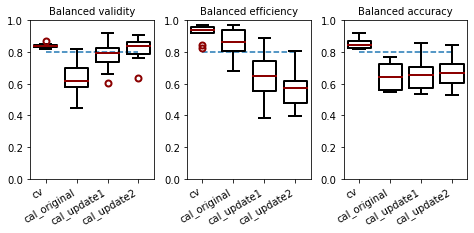

In [18]:
plt = boxplot_val_eff_acc_quer(
    evaluation_dfs=evaluation_dfs,
    measures=evaluation_measures,
    significance_level=significance_level,
    map_labels=True)